# Goal

This notebook checks model generalization performance on other dsets.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [69]:
import os, sys

# try:
#     taskid = int(os.getenv('SLURM_ARRAY_TASK_ID'))
#     do_task = True
# except:
#     taskid = 0
#     do_task = False

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [68]:
kwargs = dict(arg.split("=") for arg in sys.argv if "=" in arg)
print(kwargs)

from_cmdline = "taskid" in kwargs
if from_cmdline:
    taskid = int(kwargs["taskid"])
else:
    %load_ext autoreload
    %autoreload 2

{}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

from pathlib import Path

import SimpleITK as sitk
import pandas as pd
import numpy as np

import seaborn as sns

from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *

# Learner
import gc
gc.collect()

from helpers.losses                import dice_score
from helpers.items_constants       import *
from helpers.transforms_simplified import *
from helpers.general            import rm_prefix, get_param, get_param_default,rm_prefix, modelfn2dict, torch2sitk, sitk2torch
from helpers.model_loss_choices import get_model, get_loss
from helpers.viz                import get_mid_idx, viz_axis, viz_compare_outputs
from helpers.preprocess         import batch_get_bbox, mask2bbox
from helpers.postprocess        import get_largest_connected_component, eval_measure, eval_lcc

cuda:0
Full lbl items: 335
Removed 2 weird, new total lbl items: 333
train, valid, test 201 66 66 total 333
Cross label items:  418
All label items:  751 (abide (333) + cross_lbl (418))
Test label items:  484 (test (66) + cross_lbl (418))


In [2]:
# POST LCC DF DICT

# Items as dict 
from pathlib import Path
from helpers.items_constants import *

#items  = all_test_lbl_items
items = all_test_lbl_items #ppmi, icmb, adni, aibl, abvib, test_items
itemsd = getd(items)

def is_recent(model_fn):
    dates = [f"Aug_0{x}"  for x in range(3,10)]
    dates += [f"Aug_1{x}" for x in range(0,10)]
    return any([date in str(model_fn) for date in dates])


model_fns = sorted(Path(run_src).iterdir(), key=os.path.getmtime, reverse=True)

done = [str(model_fn) 
        for model_fn in model_fns 
        if os.path.isfile(f"{str(model_fn)}/post_lcc_df.pkl") and is_recent(model_fn)
       ]
#print(*rm_prefix(done, prefix=run_src, do_sort=True), sep="\n")
print(f"DONE: {len(done)}")

post_df_dict = {}

for done_fn in done:
    model_name = Path(done_fn).name
    #print(model_name)
    model_src = f"{run_src}/{model_name}"
    check_post_df  = pd.read_pickle(f"{model_src}/post_lcc_df.pkl")
    check_pre_df   = pd.read_pickle(f"{model_src}/pre_lcc_df.pkl")
    #check_stats_df = pd.read_pickle(f"{model_src}/stats_df.pkl")
    
    #check_stats_df = check_stats_df.style.set_caption(f"{model_name}")

    post_df_dict[model_name] = check_post_df
    
    if len(check_post_df) != len(itemsd):
        print(done_fn)
        print("Len", len(check_post_df))
        print("*" * 50)
    #display(check_post_df)
    #display(check_pre_df)
    #display(check_stats_df)

DONE: 308


In [3]:
print(*rm_prefix(done, prefix=run_src, do_sort=True), sep="\n")

model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628202024_Thu_Aug_05_2021_hr_18_min_20
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628436502_Sun_Aug_08_2021_hr_11_min_28
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628447321_Sun_Aug_08_2021_hr_14_min_28
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628493195_Mon_Aug_09_2021_hr_03_min_13
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628562710_Mon_Aug_09_2021_hr_22_min_31
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628659646_Wed_Aug_11_2021_hr_01_min_27
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_False_do_flip_True_bs_2_epochs_60_time_1628756724_Thu_Aug_12_2021_hr_04_min_25
model_CONDSEG_loss_B

In [4]:
#from helpers.general import rm_prefix, cut
#print(*rm_prefix([str(s) for s in most_recent], prefix=run_src), sep="\n")

#most_recent = sorted([Path(f"{run_src}/{key}") for key in list(post_df_dict.keys())], key=os.path.getmtime)
#print(*rm_prefix([str(s) for s in most_recent], prefix=run_src), sep="\n")

In [46]:
models_to_ensemble_list = [
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627970860_Tue_Aug_03_2021_hr_02_min_07',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978855_Tue_Aug_03_2021_hr_04_min_20',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628199814_Thu_Aug_05_2021_hr_17_min_43'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628288968_Fri_Aug_06_2021_hr_18_min_29',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628295674_Fri_Aug_06_2021_hr_20_min_21',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628302341_Fri_Aug_06_2021_hr_22_min_12'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628389599_Sat_Aug_07_2021_hr_22_min_26',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628294473_Fri_Aug_06_2021_hr_20_min_01',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628426611_Sun_Aug_08_2021_hr_08_min_43'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629170637_Mon_Aug_16_2021_hr_23_min_23',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628465251_Sun_Aug_08_2021_hr_19_min_27',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628447015_Sun_Aug_08_2021_hr_14_min_23'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629172742_Mon_Aug_16_2021_hr_23_min_59',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628397477_Sun_Aug_08_2021_hr_00_min_37',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628562656_Mon_Aug_09_2021_hr_22_min_30'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629165465_Mon_Aug_16_2021_hr_21_min_57',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628508827_Mon_Aug_09_2021_hr_07_min_33',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628490587_Mon_Aug_09_2021_hr_02_min_29'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629226110_Tue_Aug_17_2021_hr_14_min_48',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628578641_Tue_Aug_10_2021_hr_02_min_57',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628659632_Wed_Aug_11_2021_hr_01_min_27'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629229222_Tue_Aug_17_2021_hr_15_min_40',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628677940_Wed_Aug_11_2021_hr_06_min_32',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628753398_Thu_Aug_12_2021_hr_03_min_29'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629221885_Tue_Aug_17_2021_hr_13_min_38',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628770574_Thu_Aug_12_2021_hr_08_min_16',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628877896_Fri_Aug_13_2021_hr_14_min_04'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627970836_Tue_Aug_03_2021_hr_02_min_07',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978943_Tue_Aug_03_2021_hr_04_min_22',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628200038_Thu_Aug_05_2021_hr_17_min_47'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628288968_Fri_Aug_06_2021_hr_18_min_29',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628295793_Fri_Aug_06_2021_hr_20_min_23',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628295793_Fri_Aug_06_2021_hr_20_min_23'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628389599_Sat_Aug_07_2021_hr_22_min_26',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628463798_Sun_Aug_08_2021_hr_19_min_03',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628446380_Sun_Aug_08_2021_hr_14_min_13'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629164698_Mon_Aug_16_2021_hr_21_min_44',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628396669_Sun_Aug_08_2021_hr_00_min_24',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628426610_Sun_Aug_08_2021_hr_08_min_43'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629171663_Mon_Aug_16_2021_hr_23_min_41',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628504864_Mon_Aug_09_2021_hr_06_min_27',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628487258_Mon_Aug_09_2021_hr_01_min_34'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629166971_Mon_Aug_16_2021_hr_22_min_22',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628577004_Tue_Aug_10_2021_hr_02_min_30',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628560951_Mon_Aug_09_2021_hr_22_min_02'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629236438_Tue_Aug_17_2021_hr_17_min_40',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628676468_Wed_Aug_11_2021_hr_06_min_07',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628658906_Wed_Aug_11_2021_hr_01_min_15'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629228997_Tue_Aug_17_2021_hr_15_min_36',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628767575_Thu_Aug_12_2021_hr_07_min_26',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628747362_Thu_Aug_12_2021_hr_01_min_49'),
 ('model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629222436_Tue_Aug_17_2021_hr_13_min_47',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628891115_Fri_Aug_13_2021_hr_17_min_45',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628875564_Fri_Aug_13_2021_hr_13_min_26'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627970860_Tue_Aug_03_2021_hr_02_min_07',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978855_Tue_Aug_03_2021_hr_04_min_20',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628199814_Thu_Aug_05_2021_hr_17_min_43',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627970836_Tue_Aug_03_2021_hr_02_min_07',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978943_Tue_Aug_03_2021_hr_04_min_22',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628200038_Thu_Aug_05_2021_hr_17_min_47'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628288968_Fri_Aug_06_2021_hr_18_min_29',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628295674_Fri_Aug_06_2021_hr_20_min_21',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628302341_Fri_Aug_06_2021_hr_22_min_12',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628288968_Fri_Aug_06_2021_hr_18_min_29',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628295793_Fri_Aug_06_2021_hr_20_min_23',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628295793_Fri_Aug_06_2021_hr_20_min_23'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628389599_Sat_Aug_07_2021_hr_22_min_26',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628294473_Fri_Aug_06_2021_hr_20_min_01',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628426611_Sun_Aug_08_2021_hr_08_min_43',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628389599_Sat_Aug_07_2021_hr_22_min_26',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628463798_Sun_Aug_08_2021_hr_19_min_03',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628446380_Sun_Aug_08_2021_hr_14_min_13'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629170637_Mon_Aug_16_2021_hr_23_min_23',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628465251_Sun_Aug_08_2021_hr_19_min_27',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628447015_Sun_Aug_08_2021_hr_14_min_23',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629164698_Mon_Aug_16_2021_hr_21_min_44',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628396669_Sun_Aug_08_2021_hr_00_min_24',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628426610_Sun_Aug_08_2021_hr_08_min_43'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629172742_Mon_Aug_16_2021_hr_23_min_59',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628397477_Sun_Aug_08_2021_hr_00_min_37',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628562656_Mon_Aug_09_2021_hr_22_min_30',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629171663_Mon_Aug_16_2021_hr_23_min_41',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628504864_Mon_Aug_09_2021_hr_06_min_27',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628487258_Mon_Aug_09_2021_hr_01_min_34'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629165465_Mon_Aug_16_2021_hr_21_min_57',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628508827_Mon_Aug_09_2021_hr_07_min_33',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628490587_Mon_Aug_09_2021_hr_02_min_29',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629166971_Mon_Aug_16_2021_hr_22_min_22',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628577004_Tue_Aug_10_2021_hr_02_min_30',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628560951_Mon_Aug_09_2021_hr_22_min_02'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629226110_Tue_Aug_17_2021_hr_14_min_48',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628578641_Tue_Aug_10_2021_hr_02_min_57',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628659632_Wed_Aug_11_2021_hr_01_min_27',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629236438_Tue_Aug_17_2021_hr_17_min_40',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628676468_Wed_Aug_11_2021_hr_06_min_07',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628658906_Wed_Aug_11_2021_hr_01_min_15'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629229222_Tue_Aug_17_2021_hr_15_min_40',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628677940_Wed_Aug_11_2021_hr_06_min_32',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628753398_Thu_Aug_12_2021_hr_03_min_29',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629228997_Tue_Aug_17_2021_hr_15_min_36',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628767575_Thu_Aug_12_2021_hr_07_min_26',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628747362_Thu_Aug_12_2021_hr_01_min_49'),
 ('model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629221885_Tue_Aug_17_2021_hr_13_min_38',
  'model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628770574_Thu_Aug_12_2021_hr_08_min_16',
  'model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628877896_Fri_Aug_13_2021_hr_14_min_04',
  'model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1629222436_Tue_Aug_17_2021_hr_13_min_47',
  'model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628891115_Fri_Aug_13_2021_hr_17_min_45',
  'model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628875564_Fri_Aug_13_2021_hr_13_min_26')
]

In [48]:
# 3 BCE models, 3 DICE models (UNET, VNET, CONDSEG)
models_to_ensemble_list = models_to_ensemble_list[-10:]
for i,m in enumerate(models_to_ensemble_list):
    print(i,len(m))

0 6
1 6
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6


In [18]:
# models_to_ensemble = [
#     # UNET BCE, DICE (SIMPLE)
#     "model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18",
#     "model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628389599_Sat_Aug_07_2021_hr_22_min_26",
    
#     # VNET BCE, DICE (SIMPLE)
#     "model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628677940_Wed_Aug_11_2021_hr_06_min_32",
#     "model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628463798_Sun_Aug_08_2021_hr_19_min_03",
    
#     # CONDSEG BCE, DICE (SIMPLE)
#     "model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628302341_Fri_Aug_06_2021_hr_22_min_12",
#     "model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628658906_Wed_Aug_11_2021_hr_01_min_15",
    
#     # OBELISK 96 BCE, DICE (SIMPLE)
#     "model_OBELISKHYBRID_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628405192_Sun_Aug_08_2021_hr_02_min_46",
#     "model_OBELISKHYBRID_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628436691_Sun_Aug_08_2021_hr_11_min_31",
    
#     # OBELISK 144 BCE, DICE (SIMPLE)
#     "model_OBELISKHYBRID_loss_BCE_loss_full_res_144_pixdim_1.0_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628312574_Sat_Aug_07_2021_hr_01_min_02",
#     "model_OBELISKHYBRID_loss_DICE_loss_full_res_144_pixdim_1.0_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628310872_Sat_Aug_07_2021_hr_00_min_34",    
#     # UNETR
#     "model_UNETR_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628745179_Thu_Aug_12_2021_hr_01_min_12",
#     "model_UNETR_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628651501_Tue_Aug_10_2021_hr_23_min_11",
# ]

# models_to_ensemble_all = models_to_ensemble

# models_to_ensemble_names = ["UNET BCE", "UNET DICE", 
#                             "VNET BCE", "VNET DICE", 
#                             "CONDSEG BCE", "CONDSEG DICE",
#                             "OBELISK 96 BCE", "OBELISK  DICE", 
#                             "OBELISK 144 BCE", "OBELISK 144 DICE", 
#                             "UENTR BCE", "UNETR DICE", 
#                            ]
# models_names_dict = dict(zip(models_to_ensemble_names, models_to_ensemble))

# my_choice_ensemble = ["UNET BCE", "UNET DICE", 
#                             "VNET BCE", "VNET DICE", 
#                             "CONDSEG BCE", "CONDSEG DICE",
# #                             "OBELISK 96 BCE", "OBELISK  DICE", 
# #                             "OBELISK 144 BCE", "OBELISK 144 DICE", 
# #                             "UENTR BCE", "UNETR DICE", 
#                     ]

# models_to_ensemble = [models_names_dict[name] for name in my_choice_ensemble]
# print(f"My choice Ensemble {len(models_to_ensemble)}", *models_to_ensemble, sep="\n")

In [49]:
print(len(models_to_ensemble_list))

10


In [50]:
models_to_ensemble = models_to_ensemble_list[taskid]
print(f"My choice Ensemble {len(models_to_ensemble)} (taskid {taskid})", *models_to_ensemble, sep="\n")

My choice Ensemble 6 (taskid 0)
model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18
model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26
model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18
model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08
model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26


In [21]:
# inputs, labels. Check that the order matches.

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]
ranges  = [range(i,min(i+bs, len(itemsd))) for i in range(0,len(itemsd),bs)]

# get inputs, labels of first 5
full_res = tuple(96 for _ in range(3)) # 144
pixdim   = tuple(1.5 for _ in range(3))
do_condseg = False

#load labels
val_str = f"full_res_{full_res[0]}_pixdim_{pixdim[0]}_do_condseg_{do_condseg}"
transformed_labels_src = f"{data_src}/saved_transformed_labels/{val_str}"

def is_obelisk_144(fn):
    return "OBELISK" in str(fn) and "full_res_144_pixdim_1.0" in str(fn)

i = 0
    
# get stored inputs, labels
with open(f"{transformed_labels_src}/transformed_labels_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
    data = pickle.load(handle)

inputs, labels = zip(*data) # [(img,lbl), (img,lbl)] => imgs, labels
inputs = torch.stack(inputs, dim=0)
labels = torch.stack(labels, dim=0)
inputs = inputs.to(device)
print("inputs", inputs.shape, "labels", labels.shape, len(labels))

# choose fn
for fn in models_to_ensemble:
    print("*"*50); print(fn)

    # dices stored from dataframe
    metric = "dice"
    stored_dices = post_df_dict[fn][metric].values[0:5]

    # get stored predictions
    model_name = Path(fn).name

    start_src = f"{run_src}/{model_name}/to_96_" if is_obelisk_144(fn) else f"{run_src}/{model_name}/"
    with open(f"{start_src}preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        stored_preds = pickle.load(handle)
        
    # to tensor
    if is_obelisk_144(fn):
        stored_preds = [torch.tensor(pred) for pred in stored_preds]

    # recalculate preds
    _, stored_preds_post_metrics = zip(*[eval_lcc(labels[i], stored_preds[i])
                                          for i in range(bs)
                                         ])

    recalc_dices = [d["dice"] for d in stored_preds_post_metrics]
    print(*list(zip(recalc_dices, stored_dices)), sep=", ")

#val_str = "full_res_144_pixdim_1.0_do_condseg_False"
#val_str = "full_res_96_pixdim_1.5_do_condseg_False"

inputs torch.Size([5, 1, 96, 96, 96]) labels torch.Size([5, 1, 96, 96, 96]) 5
**************************************************
model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18
(0.8859430846491426, 0.8859430846491426), (0.8502285245517404, 0.8502285245517404), (0.8883544020583957, 0.8883544020583957), (0.7410177017000643, 0.7410177017000643), (0.7420462909953383, 0.7420462909953383)
**************************************************
model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10
(0.8594218311901769, 0.8594218311901769), (0.856663193238393, 0.856663193238393), (0.8667612829974454, 0.8667612829974454), (0.7793964620187305, 0.7793964620187305), (0.7035776614310647, 0.7035776614310647)
**************************************************
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_

In [22]:
# # test Pipeline

# # standard: 96 full res, pixdim 1.5
# # full_res = tuple(96 for _ in range(3)) # 144
# # pixdim   = tuple(1.5 for _ in range(3))
# # do_condseg = False

# train_itemsd = getd(train_items) # for condseg atlas choice

# val_tfm_dict = {}
# for condseg_bool in (True, False):
#     for full_res,pixdim in ((96,1.5),(144,1.0)):
#         val_tfm_dict[f"full_res_{full_res}_pixdim_{pixdim}_do_condseg_{condseg_bool}"] = \
#             get_train_valid_transforms(items=train_itemsd, pixdim=pixdim, full_res=full_res, do_condseg=condseg_bool)[1]
        
# val_tfms = val_tfm_dict["full_res_96_pixdim_1.5_do_condseg_False"]        
# test_data = Pipeline(val_tfms)(itemsd[0:5])

In [23]:
# models_to_ensemble = [
#     # UNET VNET DICE
#     "model_UNET3D_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971508_Tue_Aug_03_2021_hr_02_min_18",
#     "model_VNET_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978137_Tue_Aug_03_2021_hr_04_min_08",
#     # UNET VNET BCE
#     "model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18",
#     "model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10",
#     # OBELISK DICE BCE
#     "model_OBELISKHYBRID_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963440_Tue_Aug_03_2021_hr_00_min_04",
#     "model_OBELISKHYBRID_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963631_Tue_Aug_03_2021_hr_00_min_07",
#     # CONDSEG DICE BCE
#     "model_CONDSEG_loss_DICE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097973_Wed_Aug_04_2021_hr_13_min_26",
#     "model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26"
# ]

# models_to_ensemble_names = ["UNET DICE", "VNET DICE", 
#                             "UNET BCE", "VNET BCE", 
#                             "OBELISK 96 DICE", "OBELISK 96 BCE", 
#                             "CONDSEG DICE", "CONDESEG BCE"
#                            ]
# models_names_dict = dict(zip(models_to_ensemble_names, models_to_ensemble))

# my_choice_ensemble = ["UNET BCE", "VNET BCE"]
# models_to_ensemble = [models_names_dict[name] for name in my_choice_ensemble]

# print(f"My choice Ensemble {len(models_to_ensemble)}", *models_to_ensemble, sep="\n")

In [24]:
def rename2(fn):
    model_name2 = Path(fn).name
    model_type2 = get_param(model_name2, "model_", "_loss")

    if "loss_bs" in model_name:
        loss_type2  = get_param(model_name2, "loss_", "_bs")
    else:
        loss_type2  = get_param(model_name2, "loss_", "_full_res")

    full_res2   = get_param_default(model_name2, "full_res_", "_pixdim", 96)
    pixdim2     = get_param_default(model_name2, "pixdim_", "_do_simple", 1.5)
    do_simple2  = get_param_default(model_name2, "do_simple_", "_do_flip", False)
    do_flip2    = get_param_default(model_name2, "do_flip_", "_bs", True)
    
    # convert to bool
    do_simple2 = do_simple2 == "True"
    do_flip2   = do_flip2  == "True"
        
    if model_type2 != "OBELISKHYBRID": 
        s = f"{model_type2}" 
        if not do_simple2: 
            s += " (+aug)"
        return s
    else:
        # {model_type2}
        s = f"OBELISK {full_res2}" 
        if not do_simple2: 
            s += " (+aug)"
        return s

In [25]:
# Viz models to ensemble

metric = "dice" # false_pos

# if output doesn't intersect
undefined_val = {"false_pos": 0.0, "false_neg": 1.0}

simple_keys    = [k for k in models_to_ensemble if "do_simple_True" in k]
bce_plot_keys  = [k for k in simple_keys if "BCE_loss" in k]
dice_plot_keys = [k for k in simple_keys if "DICE_loss" in k]

data = [{"model_type": rename2(fn), "loss_type":  "DICE_loss", f"{metric}_score":min(val,1)} 
        for i,fn in enumerate(dice_plot_keys) 
        for val in post_df_dict[fn][metric].values
       ] + \
    [{"model_type":  rename2(fn), "loss_type":  "BCE_loss", f"{metric}_score":min(val,1)} 
        for i,fn in enumerate(bce_plot_keys) 
        for val in post_df_dict[fn][metric].values
       ]

# ensemble_data = \
#     [{"model_type": "ensemble",  "loss_type":  "BCE_loss", f"{metric}_score":val} for val in ensemble_bce_df[metric].values] + \
#     [{"model_type": "ensemble", "loss_type":  "DICE_loss", f"{metric}_score":val} for val in ensemble_dice_df[metric].values] + \
#     [{"model_type": "ensemble",  "loss_type":  "Combined", f"{metric}_score":val} for val in ensemble_all_df[metric].values]

# together_data = pd.DataFrame(data+ensemble_data) 

data_df = pd.DataFrame(data)
#ensemble_data = pd.DataFrame(ensemble_data)

# display(data_df.head())

,model_type,loss_type,dice_score
0,UNET3D,BCE_loss,0.885943
1,UNET3D,BCE_loss,0.850229
2,UNET3D,BCE_loss,0.888354
3,UNET3D,BCE_loss,0.741018
4,UNET3D,BCE_loss,0.742046


In [26]:
# fig, ax = plt.subplots(figsize=(12,6))

# ax = sns.boxplot(x="model_type",   y=f"{metric}_score", data=data_df, hue="loss_type", ax=ax)
# ax = sns.swarmplot(x="model_type", y=f"{metric}_score", data=data_df, hue="loss_type", color=".25")

In [27]:
# Ensemble

dice_models_to_ensemble = [fn for fn in models_to_ensemble if "DICE_loss" in fn]
bce_models_to_ensemble  = [fn for fn in models_to_ensemble if "BCE_loss" in fn]

print("Dice models", len(dice_models_to_ensemble), *dice_models_to_ensemble, sep="\n")
print("BCE models", len(bce_models_to_ensemble), *bce_models_to_ensemble, sep="\n")
print(f"All models", len(models_to_ensemble), *models_to_ensemble, sep="\n")

Dice models
0
BCE models
6
model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_03_2021_hr_02_min_18
model_VNET_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627978233_Tue_Aug_03_2021_hr_04_min_10
model_CONDSEG_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628097978_Wed_Aug_04_2021_hr_13_min_26
model_OBELISKHYBRID_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627963631_Tue_Aug_03_2021_hr_00_min_07
model_OBELISKHYBRID_loss_BCE_loss_full_res_144_pixdim_1.0_do_simple_True_do_flip_True_bs_2_epochs_60_time_1628117760_Wed_Aug_04_2021_hr_18_min_56
model_UNETR_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_False_bs_2_epochs_60_time_1628028739_Tue_Aug_03_2021_hr_18_min_12
All models
6
model_UNET3D_loss_BCE_loss_full_res_96_pixdim_1.5_do_simple_True_do_flip_True_bs_2_epochs_60_time_1627971506_Tue_Aug_0

In [28]:
import re

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]

def get_model_id(model_fn):
    """ model ids = time string """
    return re.search("(time_\d+)", model_fn).groups(0)[0]

ensemble_name = "_and_".join([get_model_id(model_fn) for model_fn in models_to_ensemble])
print(ensemble_name)

# mkdir
ensemble_src = f"{run_src}/model_ensemble/{ensemble_name}"
Path(ensemble_src).mkdir(parents=True, exist_ok=True)

if not os.path.isfile(f"{ensemble_src}/models_to_ensemble.pkl"):
    with open(f"{ensemble_src}/models_to_ensemble.pkl", 'wb') as handle:
            pickle.dump(models_to_ensemble, handle)

time_1627971506_and_time_1627978233_and_time_1628097978_and_time_1627963631_and_time_1628117760_and_time_1628028739


In [29]:
# # POST PROCESS OBELISK 144 BACK TO 1.5 voxel spacing and center crop to 96

# # convert preds => bilinear interpolation of probabilities
# from monai.transforms import Compose, Spacingd, CenterSpatialCropd
# convert_to_96_tfms = Compose([
#     Spacingd(keys=["pred"], pixdim=(1.5,1.5,1.5), mode=("bilinear")),
#     CenterSpatialCropd(keys=["pred"], roi_size=(96, 96, 96))
# ])

# # REDO OBELISKS
# obelisk_144 = [str(model_fn) 
#         for model_fn in model_fns 
#         if (("OBELISK" in str(model_fn) and "full_res_144_pixdim_1.0" in str(model_fn)) and \
#                 (os.path.isfile(f"{str(model_fn)}/preds_batch_96_bs_5.pkl")) and \
#                 (os.path.isfile(f"{str(model_fn)}/figs/metrics.png")) and \
#                 is_recent(model_fn)
#             )
#        ]

# print(len(obelisk_144), *obelisk_144[0:5], sep="\n")

In [30]:
# start = time.time()

# for model_fn in obelisk_144:
#     model_name = Path(model_fn).name
    
#     for i in range(len(batches)):
        
#         # open pixdim 1.0, full_res 144 preds
#         with open(f"{run_src}/{model_name}/preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
#             preds_144 = pickle.load(handle)
            
#         # transform to pixdim 1.5 full_res 96 preds
#         preds_96 = convert_to_96_tfms([{"pred": pred} for pred in preds_144])
        
#         with open(f"{run_src}/{model_name}/to_96_preds_batch_{i}_bs_{bs}.pkl", 'wb') as handle:
#             pickle.dump([d["pred"] for d in preds_96], handle)
            
#         print(preds_144[0].shape, preds_96[0]["pred"].shape, len(preds_96))
        
# elapsed = time.time() - start
# print(f"Elapsed: {elapsed:0.2f} s.")

In [31]:
# not all obelisk have predictions
# for i,model_fn in enumerate(obelisk_144):
#     print(i, model_fn); print("*"*50);
#     print("N files: ", len(os.listdir(model_fn))); print("*"*50);
#     #print(os.listdir(model_fn))

In [33]:
# load ensemble

ensemble_name          = "_and_".join([get_model_id(model_fn) for model_fn in models_to_ensemble])
ensemble_src           = f"{run_src}/model_ensemble/{ensemble_name}"

print(ensemble_name)

# Items as dict 
items  = all_test_lbl_items
itemsd = getd(items)

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]

# load preds
ensemble_all_majority_vote = []
ensemble_bce_majority_vote = []
ensemble_dice_majority_vote = []


time_1627971506_and_time_1627978233_and_time_1628097978_and_time_1627963631_and_time_1628117760_and_time_1628028739


In [34]:
# get all ensemble - Elapsed: Elapsed: 204.79 s. =>  4min #590.97 s. => 600 => 10min; Elapsed: 1171.70 s.

get_ensemble = True

# # create batches
# bs        = 5
# batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]
def is_obelisk_144(fn):
    return "OBELISK" in str(fn) and "full_res_144_pixdim_1.0" in str(fn)

def load_model_preds(model_name, file_range=range(0,len(batches))):
    # f"{run_src}/{model_name}/to_96_preds_batch_{i}_bs_{bs}.pkl"
    start_src = f"{run_src}/{model_name}/to_96_" if is_obelisk_144(model_name) else f"{run_src}/{model_name}/"
        
    preds = []
    for i in file_range:
        with open(f"{start_src}preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
            if is_obelisk_144(model_name):
                preds += [torch.tensor(pred) for pred in pickle.load(handle)]
            else:
                preds += pickle.load(handle)
    return preds

#######################
# get all ensemble
#######################
if get_ensemble:
    start = time.time()

    for i in range(len(batches)):
        # load each models pred (6) for (0,5), (5,10) etc => 30 preds per range
        model_preds_dict = {model_fn:load_model_preds(model_fn, file_range=range(i,i+1)) 
                            for model_fn in models_to_ensemble}

        # get lcc for each of preds
        dice_majority_votes = []
        bce_majority_votes  = []
        all_majority_votes  = []

        for bs_item in range(len(batches[i])):
            ordered_preds = [model_preds_dict[model_name] for model_name in models_to_ensemble]
            all_preds = [(model_fn, get_largest_connected_component(torch2sitk(preds[bs_item].argmax(0).byte()))) 
                         for model_fn, preds in zip(models_to_ensemble, ordered_preds)]

            dice_preds = [preds for model_fn, preds in all_preds if "DICE_loss" in model_fn]
            bce_preds  = [preds for model_fn, preds in all_preds if "BCE_loss" in model_fn]
            all_preds  = [preds for model_fn, preds in all_preds]

            # get majority vote
            labelForUndecidedPixels = 0
            if len(dice_preds) > 0: dice_majority_vote = sitk.LabelVoting(dice_preds, labelForUndecidedPixels)
            if len(bce_preds)  > 0: bce_majority_vote  = sitk.LabelVoting(bce_preds, labelForUndecidedPixels)
            all_majority_vote  = sitk.LabelVoting(all_preds, labelForUndecidedPixels)

            #print(majority_vote.GetSize())
            if len(dice_preds) > 0: dice_majority_votes.append(sitk2torch(dice_majority_vote))
            if len(bce_preds)  > 0: bce_majority_votes.append(sitk2torch(bce_majority_vote))
            all_majority_votes.append(sitk2torch(all_majority_vote))

        # save model outputs
        with open(f"{ensemble_src}/dice_preds_batch_{i}_bs_{bs}.pkl", 'wb') as handle:
            pickle.dump(dice_majority_votes, handle)

        with open(f"{ensemble_src}/bce_preds_batch_{i}_bs_{bs}.pkl", 'wb') as handle:
            pickle.dump(bce_majority_votes, handle)

        with open(f"{ensemble_src}/all_preds_batch_{i}_bs_{bs}.pkl", 'wb') as handle:
            pickle.dump(all_majority_votes, handle)

        # print(len(all_majority_votes))

    elapsed = time.time() - start
    print(f"Elapsed: {elapsed:0.2f} s.")

Elapsed: 569.53 s.


In [40]:
# load ensemble

ensemble_name          = "_and_".join([get_model_id(model_fn) for model_fn in models_to_ensemble])
ensemble_src           = f"{run_src}/model_ensemble/{ensemble_name}"

print(ensemble_name)

# Items as dict 
items  = all_test_lbl_items
itemsd = getd(items)

# create batches
bs        = 5
batches = [itemsd[i:min(i+bs, len(itemsd))] for i in range(0,len(itemsd),bs)]

# load preds
ensemble_all_majority_vote = []
ensemble_bce_majority_vote = []
ensemble_dice_majority_vote = []

start = time.time()
for i in range(len(batches)):
    with open(f"{ensemble_src}/dice_preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        ensemble_dice_majority_vote += pickle.load(handle)

    with open(f"{ensemble_src}/bce_preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        ensemble_bce_majority_vote += pickle.load(handle)

    with open(f"{ensemble_src}/all_preds_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
        ensemble_all_majority_vote += pickle.load(handle)
        
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s")

time_1627971506_and_time_1627978233_and_time_1628097978_and_time_1627963631_and_time_1628117760_and_time_1628028739
Elapsed: 1.06 s


In [41]:
full_res = tuple(96 for _ in range(3)) # 144
pixdim   = tuple(1.5 for _ in range(3))
do_condseg = False

# load transformed inputs, labels
def get_transformed_inputs_labels():
    val_str = f"full_res_{full_res[0]}_pixdim_{pixdim[0]}_do_condseg_{do_condseg}"
    transformed_labels_src = f"{data_src}/saved_transformed_labels/{val_str}"
    all_data = []
    for i in range(len(batches)):
        with open(f"{transformed_labels_src}/transformed_labels_batch_{i}_bs_{bs}.pkl", 'rb') as handle:
            all_data.append(pickle.load(handle)) # bsx1xfull_res
    return all_data

start = time.time()
all_data = get_transformed_inputs_labels()
elapsed = time.time() - start
print(f"Load transformed inputs/labels. Elapsed: {elapsed:0.2f} s")

#val_str = "full_res_144_pixdim_1.0_do_condseg_False"
#val_str = "full_res_96_pixdim_1.5_do_condseg_False"

Load transformed inputs/labels. Elapsed: 10.93 s


In [42]:
len(all_data), len(all_data[0]), len(all_data[0][0]), all_data[0][0][0].shape, all_data[0][0][1].shape # all data = 97 items, each item has batch size of 5, each item in batch is tuple = (input, label)

(97, 5, 2, torch.Size([1, 96, 96, 96]), torch.Size([1, 96, 96, 96]))

In [43]:
# print("all data = inputs/labels", len(all_data))
print("dice majority vote", len(ensemble_dice_majority_vote), 
      "bce majority vote", len(ensemble_bce_majority_vote), 
      "all majority vote", len(ensemble_all_majority_vote), sep="\n")

dice majority vote
0
bce majority vote
484
all majority vote
484


In [44]:
# get dice scores Elapsed: 107.66 s (2minn) Elapsed: 1206.66 s

# Labels (Transforms)

# for condseg
# train_itemsd = getd(train_items) # for condseg atlas choice

# val_tfm_dict = {}
# for condseg_bool in (True, False):
#     for full_res,pixdim in ((96,1.5),(144,1.0)):
#         val_tfm_dict[f"full_res_{full_res}_pixdim_{pixdim}_do_condseg_{condseg_bool}"] = \
#             get_train_valid_transforms(items=train_itemsd, pixdim=pixdim, full_res=full_res, do_condseg=condseg_bool)[1]

# val_tfms = val_tfm_dict["full_res_96_pixdim_1.5_do_condseg_False"]

# load indiv predictions
def idx2batch_idx(idx):
    for batch_idx_,range_ in enumerate(ranges):
        if idx in range_:
            batch_idx = batch_idx_
            within_batch_idx = idx - range_[0]
            return batch_idx, within_batch_idx

if get_ensemble:
    start = time.time()

    # get dice scores
    ensemble_bce_scores  = []
    ensemble_dice_scores = []
    ensemble_all_scores  = []

    # 1sec per item => 10 min
    for i,item in enumerate(itemsd):
        batch_idx, within_batch_idx = idx2batch_idx(i)
        label = torch2sitk(all_data[batch_idx][within_batch_idx][1].squeeze(0).byte()) # both label and each vote are full_res size
        if len(ensemble_bce_majority_vote)  > 0: ensemble_bce_scores.append(eval_measure(label, torch2sitk(ensemble_bce_majority_vote[i].byte())))
        if len(ensemble_dice_majority_vote) > 0: ensemble_dice_scores.append(eval_measure(label, torch2sitk(ensemble_dice_majority_vote[i].byte())))
        ensemble_all_scores.append(eval_measure(label, torch2sitk(ensemble_all_majority_vote[i].byte())))
        #ensemble_bce_scores += eval_pred(label, ensemble_bce_majority_vote[i])

    elapsed = time.time() - start
    print(f"Elapsed: {elapsed:0.2f} s")

Elapsed: 97.90 s


In [51]:
if get_ensemble:
    print("ensemble len", len(ensemble_all_scores), ensemble_all_scores[:2])
    print("dice ensemble len", len(ensemble_dice_scores))

ensemble len 484 [{'dice': 0.8661105612894104, 'false_neg': 0.1525408097390021, 'false_pos': 0.11439861218195836, 'IoU': 0.7638403990024938, 'hausdorff_dist': 3.7416573867739413}, {'dice': 0.8458386840335107, 'false_neg': 0.15955766192733017, 'false_pos': 0.14869522402757263, 'IoU': 0.7328600190738582, 'hausdorff_dist': 3.3166247903554}]
dice ensemble len 0


In [52]:
if get_ensemble:
    ensemble_all_df  = pd.DataFrame(ensemble_all_scores)
    ensemble_dice_df = pd.DataFrame(ensemble_dice_scores)
    ensemble_bce_df  = pd.DataFrame(ensemble_bce_scores)

    for df in (ensemble_all_df, ensemble_dice_df, ensemble_bce_df):
        if len(df) > 0:
            df["image"] = [item["image"] for item in itemsd]
            df["label"] = [item["label"] for item in itemsd]

    # save
    ensemble_all_df.to_pickle(f"{ensemble_src}/ensemble_all_df.pkl")
    ensemble_dice_df.to_pickle(f"{ensemble_src}/ensemble_dice_df.pkl")
    ensemble_bce_df.to_pickle(f"{ensemble_src}/ensemble_bce_df.pkl")

In [53]:
# read ensemble df    
ensemble_all_df = pd.read_pickle(f"{ensemble_src}/ensemble_all_df.pkl")
ensemble_dice_df = pd.read_pickle(f"{ensemble_src}/ensemble_dice_df.pkl")
ensemble_bce_df = pd.read_pickle(f"{ensemble_src}/ensemble_bce_df.pkl")

print(len(ensemble_all_df), len(ensemble_dice_df), len(ensemble_bce_df))
# display(ensemble_all_df.head())

484 0 484


,dice,false_neg,false_pos,IoU,hausdorff_dist,image,label
0,0.866111,0.152541,0.114399,0.763840,3.741657,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/MP-RAGE/2000-01-01_00_00_00.0/S165075/ABIDE_50011_MRI_MP-RAGE_br_raw_20120830203207657_S165075_I329085_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/seg.nii
1,0.845839,0.159558,0.148695,0.732860,3.316625,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50379/MP-RAGE/2000-01-01_00_00_00.0/S165402/ABIDE_50379_MRI_MP-RAGE_br_raw_20120830233630136_S165402_I329412_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50379/seg.nii
2,0.876476,0.093790,0.151369,0.780113,3.162278,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50008/MP-RAGE/2000-01-01_00_00_00.0/S164971/ABIDE_50008_MRI_MP-RAGE_br_raw_20120830194128385_S164971_I328981_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50008/seg.nii
3,0.752987,0.311256,0.169552,0.603833,5.000000,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50333/MP-RAGE/2000-01-01_00_00_00.0/S165330/ABIDE_50333_MRI_MP-RAGE_br_raw_20120830225747452_S165330_I329340_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50333/seg.nii
4,0.701176,0.432872,0.081793,0.539855,8.944272,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50060/MP-RAGE/2000-01-01_00_00_00.0/S164445/ABIDE_50060_MRI_MP-RAGE_br_raw_20120830160721935_S164445_I328442_corrected_n4.nii,/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50060/seg.nii


In [58]:
models_to_ensemble_all = models_to_ensemble

,model_type,loss_type,dice_score
0,UNET3D,DICE_loss,0.865710
1,UNET3D,DICE_loss,0.842011
2,UNET3D,DICE_loss,0.866526
3,UNET3D,DICE_loss,0.731509
4,UNET3D,DICE_loss,0.710060


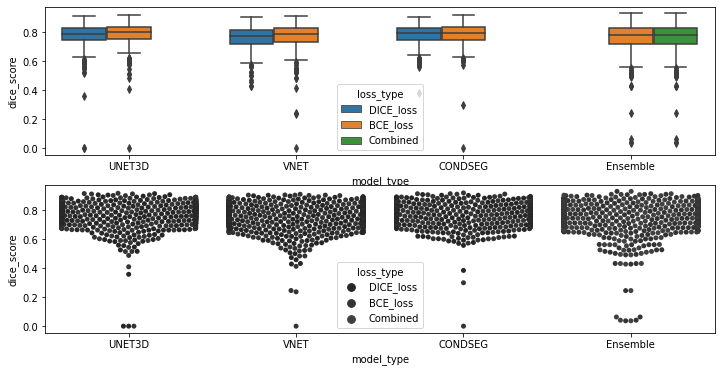

In [59]:
# Viz models to ensemble

metric = "dice" # false_pos

# if output doesn't intersect
undefined_val = {"false_pos": 0.0, "false_neg": 1.0}

simple_keys    = [k for k in models_to_ensemble_all] #[k for k in models_to_ensemble if "do_simple_True" in k]
bce_plot_keys  = [k for k in simple_keys if "BCE_loss" in k]
dice_plot_keys = [k for k in simple_keys if "DICE_loss" in k]

data = [{"model_type": rename2(fn), "loss_type":  "DICE_loss", f"{metric}_score":min(val,1)} 
        for i,fn in enumerate(dice_plot_keys) 
        for val in post_df_dict[fn][metric].values
       ] + \
    [{"model_type":  rename2(fn), "loss_type":  "BCE_loss", f"{metric}_score":min(val,1)} 
        for i,fn in enumerate(bce_plot_keys) 
        for val in post_df_dict[fn][metric].values
       ]

ensemble_data = []
ensemble_dfs   = (ensemble_bce_df, ensemble_dice_df, ensemble_all_df)
ensemble_types = ("BCE_loss", "DICE_loss", "Combined") 
for df, loss_type in zip(ensemble_dfs, ensemble_types):
    if len(df) > 0:
        ensemble_data += [{"model_type": "Ensemble",  "loss_type":  loss_type, f"{metric}_score":val} 
                          for val in df[metric].values]
    
together_data_df = pd.DataFrame(data+ensemble_data) 
data_df          = pd.DataFrame(data)
ensemble_df      = pd.DataFrame(ensemble_data)

# display(data_df.head())

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
# ax = sns.boxplot(x="model_type",   y=f"{metric}_score", data=together_data_df, hue="loss_type", ax=axes[0])
# ax = sns.swarmplot(x="model_type", y=f"{metric}_score", data=together_data_df, hue="loss_type", color=".25", ax=axes[1])

Text(0, 0.5, 'Dice score')

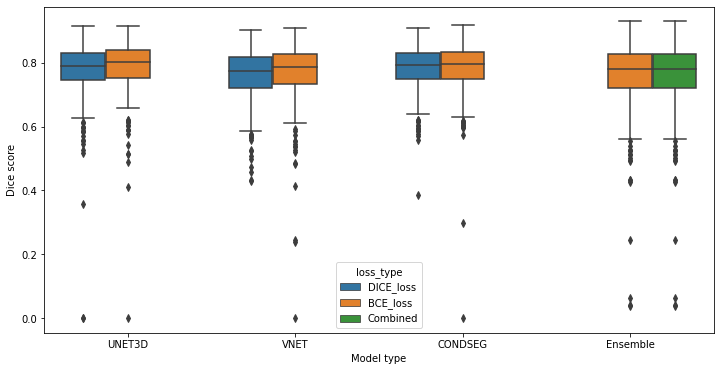

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax = sns.boxplot(x="model_type",   y=f"{metric}_score", data=together_data_df, hue="loss_type", ax=axes)
ax.set_xlabel("Model type"); ax.set_ylabel("Dice score")

#ax = sns.swarmplot(x="model_type", y=f"{metric}_score", data=together_data_df, hue="loss_type", ax=axes[1])

#ax.set_title("Fig 2a. Model Performance on Test Set")
#fig.savefig(f"fig_2a_three_ensemble.png", bbox_inches='tight', dpi = 1000)

# End

In [ ]:
print("Done")